# Building a GAN for creating random handwritten digits
This notebook trains a gan which is able to generate handwirtten digits using the MNIST dataset. This notebook is inspired by [this](https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) blog post.



In [1]:
import keras

from keras.models import Sequential

from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True      
sess = tf.Session(config = config)

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pylab as plt

from tqdm import tnrange
import numpy as np

# Building the Network

In [3]:
# MNIST dataset consists of 28x28 grayscale images
img_rows = 28
img_cols = 28
channel = 1

## Building the Discriminator

In [4]:
depth = 64
dropout = 0.4


In [5]:
discriminator = Sequential()

input_shape = (img_rows, img_cols, channel)

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))

discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)  

In [6]:
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)

discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='binary_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])

## Building the Generator

In [7]:
dropout = 0.4
depth = 64+64+64+64
dim = 7

In [8]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(1, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Building the Adversarial
The adversarial model is build by combining both the discriminator and generator

In [9]:
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)

adversarial_model = Sequential()
adversarial_model.add(generator)
adversarial_model.add(discriminator)

adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Train the Network

In [10]:
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, img_rows, img_cols, 1).astype(np.float32)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

In [12]:
def train(batch_size=256, train_steps=2000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data
        images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
        # Create noise in range -1 to 1 as input for the generator to generate the fake images
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = generator.predict(noise)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        input_data = np.concatenate((images_train, images_fake))
        input_labels = np.ones([2*batch_size, 1])
        input_labels[batch_size:, :] = 0
        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate more realistic images
        input_labels = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        adversarial_loss = adversarial_model.train_on_batch(noise, input_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)

        if i % 100 == 0:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

In [13]:
discriminator_losses, adversarial_losses, sample_images = train()

Instructions for updating:
Use tf.cast instead.



## Plot Evolution of Generated Images (Ones)

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

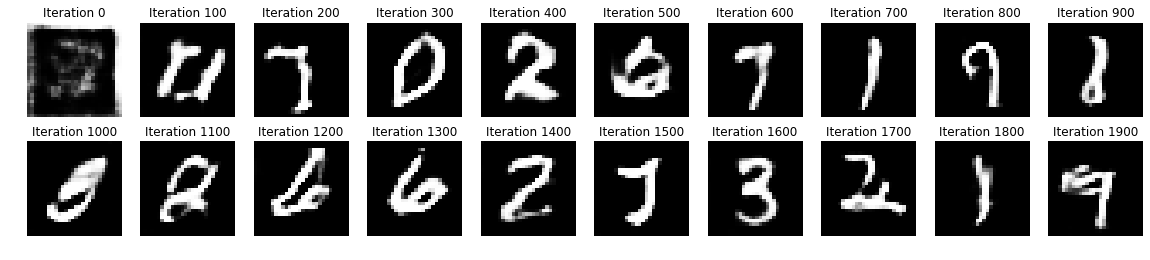

In [15]:
plt.figure(figsize=(20,4))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows)), cmap='gray')
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

## Plot Training History

Text(0.5, 1.0, 'Adversarial Accuracy')

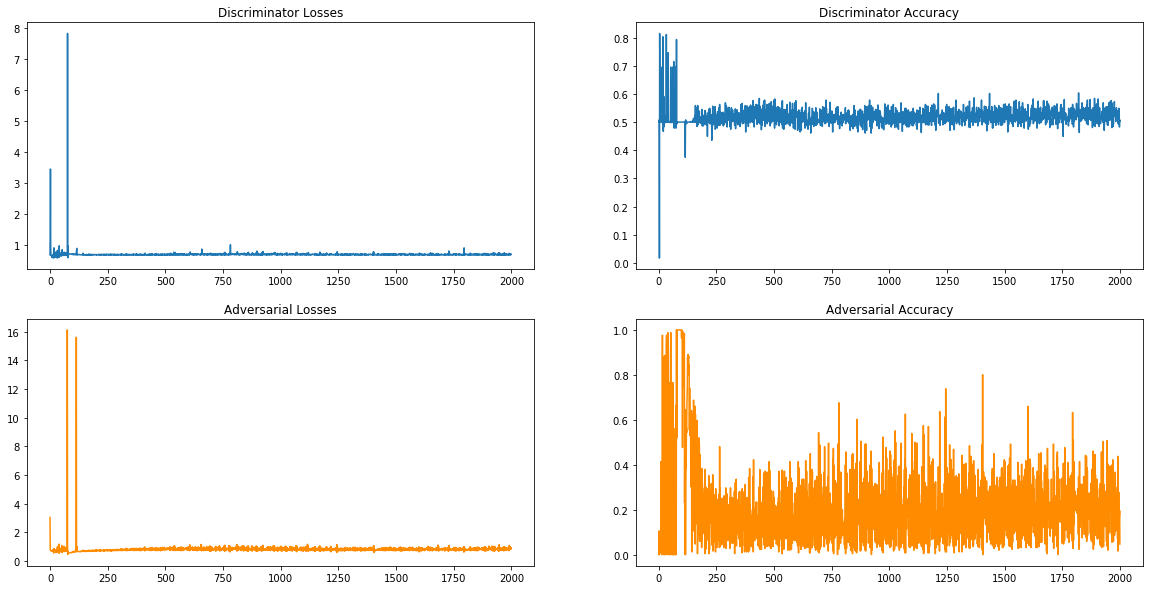

In [16]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Discriminator Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Adversarial Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Adversarial Accuracy")

# Generating Images

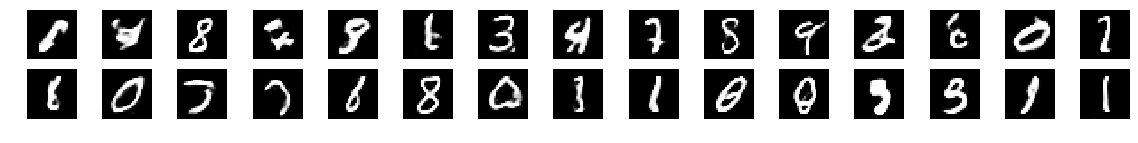

In [17]:
noise = np.random.uniform(-1.0, 1.0, size=[30, 100])
fake_images = generator.predict(noise)

plt.figure(figsize=(20,2))
for i, fake_image in enumerate(fake_images, 1):
    plt.subplot(2, 15, i)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows)), cmap='gray')
    plt.axis('off')